<a href="https://colab.research.google.com/github/mar-an/exercise/blob/master/wwwAnalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz 
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz 
!pip install -q findspark

import os
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()

from pyspark.sql.types import * 
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [3]:
import re
import pandas as pd

In [9]:
import glob

raw_data_files = glob.glob('sample_data/*.gz')
base_df = spark.read.text(raw_data_files)
base_df_rdd = base_df.rdd

In [7]:
ls -all /content/sample_data/ | grep .gz

-rw-r--r-- 1 root root 16633316 Jun  1 08:49 NASA_access_log_Aug95.gz
-rw-r--r-- 1 root root 20213733 Jun  1 08:49 NASA_access_log_Jul95.gz


In [10]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

In [11]:
base_df_rdd.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

In [12]:
print((base_df.count(), len(base_df.columns)))

(3461612, 1)


In [13]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

In [14]:
type(sample_logs)

list

Formal logu serwera WWW


**remotehost** 	Remote hostname (or IP number if DNS hostname is not available or if DNSLookup is off).

**rfc931** 	The remote logname of the user if at all it is present.

**authuser** 	The username of the remote user after authentication by the HTTP server.

**[date]** 	Date and time of the request.

**"request"** 	The request, exactly as it came from the browser or client.

**status**	The HTTP status code the server sent back to the client.

**bytes** 	The number of bytes (Content-Length) transferred to the client.

definicja wyrażenia reglarngo dla pozyskania danych hosta

In [25]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

definicja wyrażenia reglarngo dla pozyskania danych TimeStamp

In [26]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

In [ ]:
definicja wyrażenia reglarngo dla pozyskania danych Request (wstępnie podzielona po spacjach)

In [27]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

definicja wyrażenia reglarngo dla pozyskania danych Status

In [28]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


definicja wyrażenia reglarngo dla pozyskania danych Content Size

In [29]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']




Połączenie wszystkich danych w jednej DataFrame

Wstawiamy dane pozyskane przez wyrażenia regularne do wspólnej ramki w odrębnych kolumnach (metoda alias)


In [30]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    


**Czyszczenie danych**

Brakujące i zerowe wartości są zmorą analizy danych i uczenia maszynowego. Zobaczmy, jak dobrze działała nasza logika analizowania i ekstrakcji danych. Najpierw sprawdźmy, czy w oryginalnej ramce danych nie ma wierszy o wartości null.

Szukanie wierszy o wartości NULL w oryginalnym dataFrame

In [23]:
(base_df
    .filter(base_df['value']
               .isNull())
    .count())

0

Szukanie czy któreś z poszcególnych składników naszego zbioru ma wartośc NULL. To by oznaczało że poprzednia akcja pozyskiwania danych za pomoca regex zakończyła sie niepowodzeniem

In [31]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33904

Szukanie którz kolumn ma wartośc NULL

In [32]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+




Budowa ramki z danymi zawierającej konkretne rekordów które mają wartość NULL dla content sizes.

Sprawdzenie odbywa sie na oryginalnych danych (base_df)

Tylda oznacza że wyrażenie regularne dla badanego rekordu nie zostało spełnione

In [38]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

33904


Wyświetlenie wierszy z wadliwym content size 

In [39]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

Zastąpienie wadliwych content_size wartościa 0 w logs_df (oryginalne dane zostaja nienaruszone)

In [41]:
logs_df = logs_df.na.fill({'content_size': 0})

Sprawdzenie wartości NULL

In [42]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Szukanie i naprawa kolumn z polami empty

In [ ]:
bad_rows_df = logs_df.filter(logs_df['host'] == "")
bad_rows_df.count()

In [ ]:
logs_df.where("method == ''").count()

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
logs_df.select([count(when(col(c) == '', c)).alias(c) for c in logs_df.columns]).show()

Zmiana pustych wartości na 'None'

In [ ]:
logs_df = logs_df.select([when(col(c)=="",'None').otherwise(col(c)).alias(c) for c in logs_df.columns])

In [ ]:
d1 = logs_df.select([when(col(c)== '','None').otherwise(col(c)).alias(c) for c in logs_df.columns])
d1.show()

Funkcja do konwersji timestamp

In [49]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [47]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [50]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

Konwersja TimeStamp z uzyciem naszej funkcji na ramce logs.df

In [51]:
#wywołanie funkcji dla pojedyńczej wartośći TS
udf_parse_time = udf(parse_clf_time)   

#SQL zamieniająct TS
logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(n=10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [52]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


cashowanie naszego zbioru danych dla dalszego (szybszego) uzycia

In [53]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

**Statystyki Content Size**

Obliczmy statystyki dotyczące rozmiarów zawartości zwracanej przez serwer sieciowy. 
W szczególności chcielibyśmy wiedzieć, jakie są średnie, minimalne i maksymalne rozmiary treści.

Możemy obliczyć statystyki, wywołując .describe () w kolumnie content_size w logs_df. 

Funkcja .describe () zwraca liczbę, średnią, odchylenie standardowe, min i maks.

In [56]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


To samo co powyżej w SQL

In [55]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


**Analiza statusu serwera Status Code**

 komendy obliczają które wartości kodu stanu pojawiają się w danych i ile razy. 

In [61]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('count', ascending=False)
                     .cache())

print('Total distinct HTTP Status Codes:', status_freq_df.show())

+------+-------+
|status|  count|
+------+-------+
|   200|3100524|
|   304| 266773|
|   302|  73070|
|   404|  20899|
|   403|    225|
|   500|     65|
|   501|     41|
|   400|     15|
+------+-------+

Total distinct HTTP Status Codes: None


In [60]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
7,200,3100524
6,304,266773
5,302,73070
4,404,20899
3,403,225
2,500,65
1,501,41
0,400,15



**Analiza dla adresów zdalnych hostów**

Wykaz hostów, które często uzyskiwały dostęp do serwera.<br>
Licznik oznacza ilość prób odpytania serwera

In [ ]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(20))

host_sum_df.show(n=20, truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|None                |7660 |
|siltb10.orl.mmc.com |7573 |
|www-a2.proxy.aol.com|7516 |
|www-b2.proxy.aol.com|7266 |
|piweba2y.prodigy.com|7246 |
|www-b3.proxy.aol.com|7218 |
|www-d4.proxy.aol.com|7211 |
|www-b5.proxy.aol.com|7080 |
|www-d2.proxy.aol.com|6984 |
|www-b4.proxy.aol.com|6972 |
|www-d3.proxy.aol.com|6895 |
|webgate1.mot.com    |6749 |
+--------------------+-----+



**Top 20 EndPoints**

20 najczęstszych endpoint - adresów URL które odwiedzali użytkownicy.<br>
Aby wykonać to zadanie, zaczynamy od naszego logs_df i grupujemy według kolumny punktu końcowego, agregujemy według liczby i sortujemy w porządku malejącym, tak jak w poprzednim pytaniu.

In [66]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [67]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


**Top Ten Error Endpoints**

10 adresów endpoint które zwracaja kod inny niż 200

In [68]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

error_endpoints_freq_df.show(truncate=False)

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



**Liczba unikalnych hostów**

Jaka była całkowita liczba unikalnych hostów, którzy odwiedzili witrynę NASA w ciągu tych dwóch miesięcy?

In [69]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

**Liczba unikalnych hostów(adrsów zródłowych) dziennie**

Aby zapoznać się z zaawansowanym przykładem, przyjrzyjmy się sposobowi określania liczby unikalnych hostów w całym dzienniku z dnia na dzień. To obliczenie da nam liczbę unikalnych hostów dziennie.

Chcielibyśmy, aby ramka DataFrame została posortowana według rosnącego dnia miesiąca, który obejmuje dzień miesiąca i powiązaną liczbę unikalnych hostów w tym dniu.

Tworzymy ramke danych z nazwą hosta i dniem miesiąca

In [71]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(50, truncate=False)
#host_day_df.count()

+-------------------------+---+
|host                     |day|
+-------------------------+---+
|199.72.81.55             |1  |
|unicomp6.unicomp.net     |1  |
|199.120.110.21           |1  |
|burger.letters.com       |1  |
|199.120.110.21           |1  |
|burger.letters.com       |1  |
|burger.letters.com       |1  |
|205.212.115.106          |1  |
|d104.aa.net              |1  |
|129.94.144.152           |1  |
|unicomp6.unicomp.net     |1  |
|unicomp6.unicomp.net     |1  |
|unicomp6.unicomp.net     |1  |
|d104.aa.net              |1  |
|d104.aa.net              |1  |
|d104.aa.net              |1  |
|129.94.144.152           |1  |
|199.120.110.21           |1  |
|ppptky391.asahi-net.or.jp|1  |
|net-1-141.eden.com       |1  |
|ppptky391.asahi-net.or.jp|1  |
|205.189.154.54           |1  |
|waters-gw.starway.net.au |1  |
|ppp-mia-30.shadow.net    |1  |
|205.189.154.54           |1  |
|alyssa.prodigy.com       |1  |
|ppp-mia-30.shadow.net    |1  |
|dial22.lloyd.com         |1  |
|smyth-p

Nastepnie tworzymy dataFrame podobną ale bez duplikatów nazwy hosta

In [76]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(10, truncate=False)
#host_day_distinct_df.count()

+-------------------------+---+
|host                     |day|
+-------------------------+---+
|129.94.144.152           |1  |
|slip1.yab.com            |1  |
|205.184.190.47           |1  |
|204.120.34.71            |1  |
|ppp3_130.bekkoame.or.jp  |1  |
|gclab014.ins.gu.edu.au   |1  |
|www.world.net            |1  |
|ad08-007.compuserve.com  |1  |
|dd07-024.compuserve.com  |1  |
|server03.zrz.tu-berlin.de|1  |
+-------------------------+---+
only showing top 10 rows



Kolejna dataFrame z unikalna ilościa hostów na dzień

In [77]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
5,6,10133
6,7,10048
7,8,7112
8,9,6699
9,10,8532


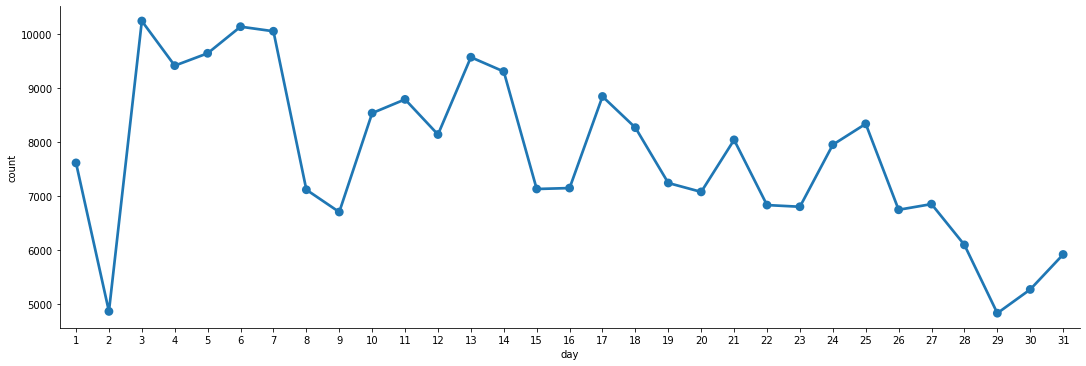

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=3)

**Wizualizacja 404 błędów tygodniowo**

Przyjrzyjmy się teraz naszym 404 rekordom tymczasowo (według czasu). Podobnie jak w przykładzie pokazującym liczbę unikalnych dziennych hostów, podzielimy żądania 404 według dni i otrzymamy dzienne liczby posortowane według dnia w plik errors_by_date_sorted_df

Utwórz ramkę 'not_found' zawierającą tylko rekordy dziennika z kodem stanu 404 (nie znaleziono). 

In [79]:
#utworzenie ramki dla statusu 404
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()

#grupowanie, sortowanie wyników
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.weekofyear('time').alias('week'))
                                .count()
                                .sort("week"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,week,count
0,26,607
1,27,3188
2,28,2796
3,29,2697
4,30,1555
5,31,1502
6,32,2197
7,33,1921
8,34,2509
9,35,1927


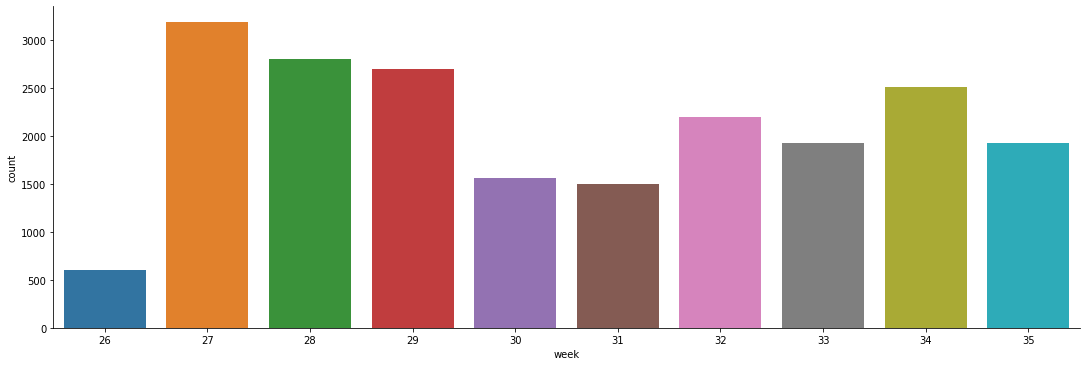

In [80]:
c = sns.catplot(x='week', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='bar', height=5, aspect=3)